<a href="https://colab.research.google.com/github/donw385/DS-Sprint-01-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
1+1

2

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import itertools
import urllib
import csv
import functools
from statistics import mean, stdev

In [0]:
def alltours_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): 
    "Choose the tour with the minimum tour length."
    return min(tours, key=tour_length)

# TO DO: Data types: cities, tours, Functions: alltours, tour_length


In [0]:
alltours = itertools.permutations 

In [55]:
cities = {1, 2, 3}

list(alltours(cities))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [0]:
def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

# TO DO: Functions: distance, Data types: cities

In [0]:
# Cities are represented as Points, which are a subclass of complex numbers

class Point(complex):
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)
    
City = Point

def distance(A, B): 
    "The distance between two points."
    return abs(A - B)

In [58]:
A = City(3, 0)
B = City(0, 4)
distance(A, B)

5.0

In [59]:
{City(random.randrange(1000), random.randrange(1000)) for c in range(6)}


{(260+144j), (318+574j), (327+237j), (42+829j), (647+773j), (881+441j)}

In [0]:
def Cities(n, width=900, height=600, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset(City(random.randrange(width), random.randrange(height))
                     for c in range(n))

In [62]:
# A set of 5 cities
Cities(5)

frozenset({(172+20j), (234+40j), (393+7j), (671+296j), (696+415j)})

In [63]:
# The exact same set of 5 cities each time
[Cities(5) for i in range(3)]

[frozenset({(172+20j), (234+40j), (393+7j), (671+296j), (696+415j)}),
 frozenset({(172+20j), (234+40j), (393+7j), (671+296j), (696+415j)}),
 frozenset({(172+20j), (234+40j), (393+7j), (671+296j), (696+415j)})]

In [64]:
# A different set of 5 cities each time
[Cities(5, seed=i) for i in range(3)]

[frozenset({(41+265j), (414+310j), (523+497j), (776+430j), (864+394j)}),
 frozenset({(29+476j), (637+261j), (759+367j), (794+255j), (814+542j)}),
 frozenset({(211+473j), (439+494j), (585+33j), (591+15j), (832+503j)})]

In [65]:
alltours_tsp(Cities(8))


((6+546j),
 (199+147j),
 (350+65j),
 (737+26j),
 (847+187j),
 (891+465j),
 (554+374j),
 (505+548j))

In [66]:
tour_length(alltours_tsp(Cities(8)))


2509.307587720301

In [0]:
def plot_tour(tour): 
    "Plot the cities as circles and the tour as lines between them."
    plot_lines(list(tour) + [tour[0]])
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p.x for p in points], [p.y for p in points], style)
    plt.axis('scaled'); plt.axis('off')

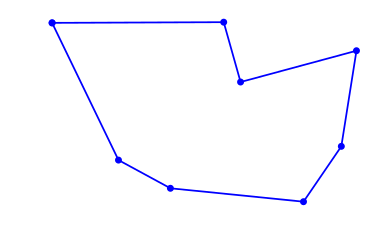

In [68]:
plot_tour(alltours_tsp(Cities(8)))

In [0]:
def plot_tsp(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t1 - t0, algorithm.__name__))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

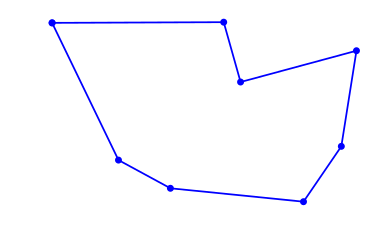

8 city tour with length 2509.3 in 0.168 secs for alltours_tsp


In [70]:
plot_tsp(alltours_tsp, Cities(8))


In [71]:
list(alltours({1, 2, 3}))


[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [0]:
def alltours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + Tour(rest)
            for rest in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

Tour = list  # Tours are implemented as lists of cities

In [73]:
alltours({1, 2, 3})


[[1, 2, 3], [1, 3, 2]]

In [74]:
alltours({1, 2, 3, 4})


[[1, 2, 3, 4],
 [1, 2, 4, 3],
 [1, 3, 2, 4],
 [1, 3, 4, 2],
 [1, 4, 2, 3],
 [1, 4, 3, 2]]

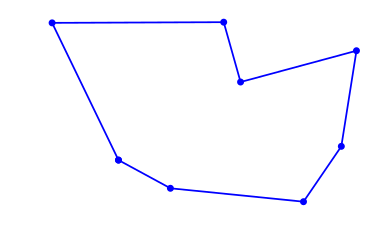

8 city tour with length 2509.3 in 0.029 secs for alltours_tsp


In [75]:
plot_tsp(alltours_tsp, Cities(8))


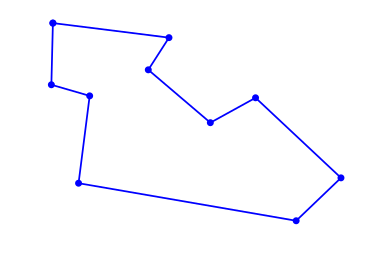

10 city tour with length 2291.8 in 2.446 secs for alltours_tsp


In [76]:
plot_tsp(alltours_tsp, Cities(10))


In [0]:
def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    start = first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda c: distance(c, A))

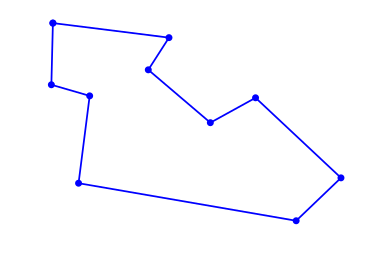

10 city tour with length 2291.8 in 2.369 secs for alltours_tsp


In [78]:
plot_tsp(alltours_tsp, Cities(10))


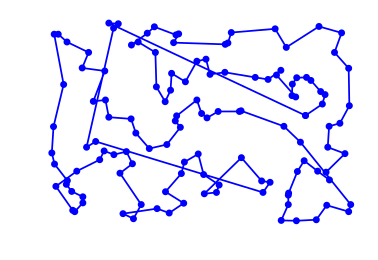

125 city tour with length 8095.3 in 0.005 secs for nn_tsp


In [82]:
plot_tsp(nn_tsp, Cities(125))


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

This is solving the Traveling Salesman Problem, which states that given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?

2.  What was the most challenging part of what you did?

It was very challenging understanding the code, as we have not yet learned complex data science, and being able to follow the logic of the code was a bit tough.

3.  What was the most interesting thing you learned?

A very complex problem can be illustrated relatively simply with python. A large number of cities (I chose 125) can calculated very quickly

4.  What area would you like to explore with more time?

Detailed understanding of the code necessary to do this problem. Additionally, I tried other notebooks, but had a lot of trouble pulling data, and they were using advanced functions I didn't know how to use, so got a lot of error messages, so hopefully will be able to tackle these once I get my more python training.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about